In [1]:
# requires separate environment for cellpose - older versions of numpy (see segmentation.yaml)
import os
import os.path as path
import sys
import numpy as np
import importlib
import tifffile
import matplotlib.pyplot as plt
from cellpose import models, io, plot, utils
from collections import defaultdict
from cellpose.io import imread
from matplotlib.patches import Polygon, Rectangle
import skimage
from scipy.ndimage import distance_transform_edt

from skimage import measure
import pandas as pd
import json

io.logger_setup()

# reproduce saved results
import random
random.seed(123)
np.random.seed(123)
import torch
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2025-05-08 11:29:58,924 [INFO] WRITING LOG OUTPUT TO /Users/jabrand2/.cellpose/run.log
2025-05-08 11:29:58,925 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	darwin 
python version: 	3.8.5 
torch version:  	2.2.2


In [2]:
# reading in util functions:
# notebook directory
current_dir = os.getcwd()

# project directory
root_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
os.chdir(root_dir)

# for importing utils
sys.path.append(os.path.join(root_dir, 'src', 'functions'))

import segmentation_utils

In [9]:
# image file 
img_path = os.path.join(root_dir, 'example_data', 'anal_cancer', 'processed')

# List all TIFF files in the directory
c7 = tifffile.imread(os.path.join(img_path, 'C-7.ome.tif'))
marker_info = os.path.join(root_dir, 'example_data', 'anal_cancer', 'processed')

marker_info = pd.read_csv(os.path.join(root_dir, 
                                       'example_data', 'anal_cancer','raw', 'channelnames.txt'),
                          header = None)

marker_info = list(marker_info.iloc[:,0])

In [11]:
# normalize if not 0-255 range for pixel intensity
image_stack = segmentation_utils.normalize_image(c7)

In [12]:
# subset to small portion of image for testing, focusing on landmark + diverse cell types exist here
image_sset = image_stack[:, 500:1500, 500:1500]

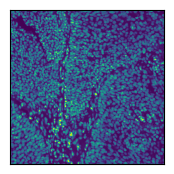

In [13]:
plt.figure(figsize = (2, 2))
plt.imshow(image_sset[0,:,:]) # DAPI channel in first image slice
plt.xticks([])
plt.yticks([])
plt.show()

In [14]:
# nuclei model for segmentation, cell boundaries expanded in later step
model = models.Cellpose(model_type = 'nuclei')

2025-05-08 11:30:45,007 [INFO] >>>> using CPU
2025-05-08 11:30:45,011 [INFO] >>>> using CPU
2025-05-08 11:30:45,013 [INFO] >> nuclei << model set to be used
2025-05-08 11:30:45,095 [INFO] >>>> loading model /Users/jabrand2/.cellpose/models/nucleitorch_0
2025-05-08 11:30:45,192 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)


2025-05-08 11:30:45,909 [INFO] channels set to [0, 0]
2025-05-08 11:30:45,912 [INFO] ~~~ FINDING MASKS ~~~
2025-05-08 11:30:55,155 [INFO] >>>> TOTAL TIME 9.25 sec


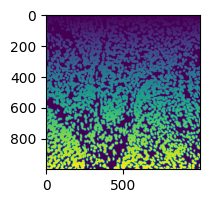

In [15]:
# see documentation for cellpose for setting parameters:

# https://cellpose.readthedocs.io/en/latest/api.html
# Stringer, C. et al. Cellpose: a generalist algorithm for cellular segmentation. 
# Nat Methods 18, 100â€“106 (2021). https://doi.org/10.1038/s41592-020-01018-x

masks, flows, styles, diameter = model.eval(image_sset[0,:,:], 
                                            channels = [0, 0], # DAPI
                                            # diameter = 30, # will predict if not provided
                                            cellprob_threshold = -3, # default is 0 (sigmoid ouput -6 to 6 range, see cellpose documentation)
                                            flow_threshold = 0.8, 
                                            resample = False, 
                                            channel_axis = 0)

plt.figure(figsize = (2,2))
plt.imshow(masks)

In [16]:
# this can be skipped and used masks / outlines for donwstream expression measures if desired
expanded_masks = segmentation_utils.expand_areas(nuclear_masks = masks, expansion_distance = 5)
outlines = utils.outlines_list(masks)
expanded_outlines = utils.outlines_list(expanded_masks)

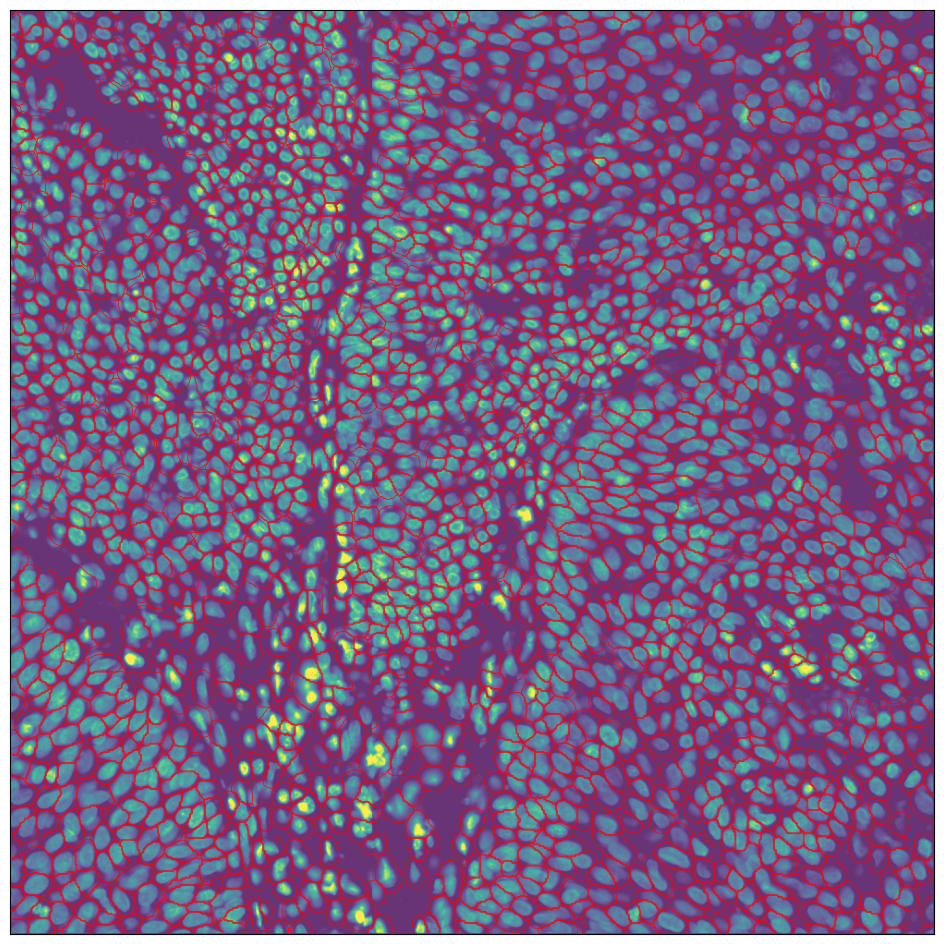

In [17]:
# polygons around points, to be used for average expression measures
plt.figure(figsize = (12, 12))
plt.imshow(image_sset[0, :, :], alpha = 0.8, vmin = 20, vmax = 255)
plt.xticks([])
plt.yticks([])
for outline in expanded_outlines:
    plt.plot(outline[:,0], outline[:,1], color = 'r', linewidth = 0.5)

In [23]:
# saving out segmentations from model
# non-expanded (nuclear)
io.masks_flows_to_seg(images = image_stack, # first image in stack (if processing multiple images)
                      masks = masks, 
                      flows = flows, 
                      file_names = './example_data/anal_cancer/segmentations/c7_susbet', 
                      channels = [0,0], 
                      diams = 30)

# expanded (cell area) & used for features calculations
io.masks_flows_to_seg(images = image_stack, 
                      masks = expanded_masks, 
                      flows = flows, 
                      file_names = './example_data/anal_cancer/segmentations/c7_subset_expanded', 
                      channels = [0,0], 
                      diams = 30)

In [24]:
# load back segmentations
segs = np.load(os.path.join(root_dir,
                            'example_data/anal_cancer/segmentations/c7_subset_expanded_seg.npy'), 
               allow_pickle = True).item()

# if using nonexpanded: 
#non_expanded_segs = np.load(os.path.join(root_dir,
#                            'example_data/anal_cancer/segmentations/c7_subset_seg.npy'), 
#               allow_pickle = True).item()

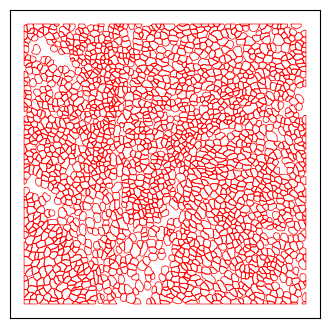

In [25]:
# showing only cell segmentations, inverted relative to image (need -1*Y coord)
# consider bottom right coordinate as landmark
plt.figure(figsize = (4, 4))
plt.xticks([])
plt.yticks([])
for outline in expanded_outlines:
    plt.plot(outline[:,0], -1*outline[:,1], color = 'r', linewidth = 0.5) # inverted y image rendering 

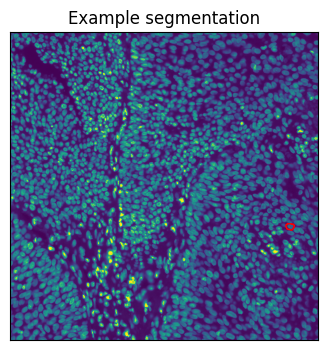

In [26]:
# example of identifying individual cells by polgyon
cell_ix = np.random.randint(0, len(expanded_outlines))
polygon_vertices = expanded_outlines[cell_ix] 
x,y = polygon_vertices[:,0], polygon_vertices[:,1]

plt.figure(figsize = (4,4))
plt.imshow(image_sset[0,:,:])
plt.plot(x, y, color = 'red', linewidth = 1)
plt.title('Example segmentation')
plt.xticks([]) 
plt.yticks([])
plt.show()

In [27]:
# testing:
num_rows = len(expanded_outlines) # preparing expression matrix
df = pd.DataFrame({f'{marker}_Cell_Mean': [0] * num_rows for marker in marker_info})

#for i in range(len(marker_info)):
#    exprs = measure.regionprops_table(masks, 
#                                      intensity_image = image[i,:,:], 
#                                      properties = ['label', 'mean_intensity'])
#        df.iloc[:,i] = exprs['mean_intensity']





In [28]:
# averaging pixel intensity in each mask
exprs = segmentation_utils.average_expression(image = image_sset, 
                                              masks = expanded_masks,
                                              outlines = expanded_outlines,
                                              marker_info = marker_info,
                                              log = True, # log noramlize values
                                              clip_low = 0.02, # clamp to bottom and top %
                                              clip_high = 0.98)

clipping values between: 2.0 - 98.0 %-iles


In [29]:
importlib.reload(segmentation_utils)

<module 'segmentation_utils' from '/Users/jabrand2/Desktop/fluoroforest/src/functions/segmentation_utils.py'>

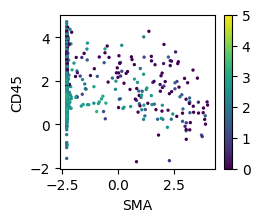

In [31]:
# Expression of example celltype markers is consistent with expectation
plt.figure(figsize = (2.5,2))
plt.scatter(x = exprs['SMA_Cell_Mean'], 
            y = exprs['CD45_Cell_Mean'], 
            s = 2, c = exprs['PanCK_Cell_Mean'], 
            vmin = 0, vmax = 5, # set depending on background intensities / max intensities
            cmap = 'viridis')
plt.colorbar()
plt.xlabel('SMA')
plt.ylabel('CD45')
plt.show()

In [32]:
# calculate centroids from outlines and add to final dataframe
centroids = [segmentation_utils.calculate_centroid(polygon) for polygon in expanded_outlines]
x_y = pd.DataFrame(centroids, columns=['Centroid_X', 'Centroid_Y'])
plot_df = pd.concat([exprs, x_y], axis = 1)

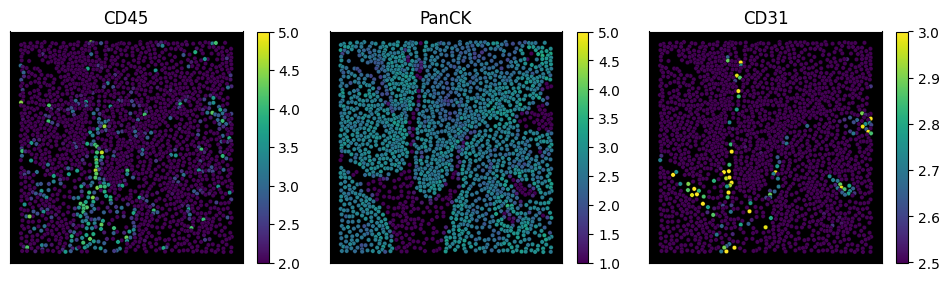

In [48]:
# Plot on averaged expression data
markers = {
    'CD45': {'column': 'CD45_Cell_Mean', 'vmin': 2, 'vmax': 5, 'title': 'CD45'},
    'PanCK': {'column': 'PanCK_Cell_Mean', 'vmin': 1, 'vmax': 5, 'title': 'PanCK'},
    'CD31': {'column': 'CD31_Cell_Mean', 'vmin': 2.5, 'vmax': 3, 'title': 'CD31'}
}

fig, axes = plt.subplots(1, len(markers.keys()), figsize = (12, 3),gridspec_kw = {'wspace': 0.1})

# Plot each marker
for ax, (marker, info) in zip(axes, markers.items()):
    ix = int(np.where(plot_df.columns == info['column'])[0])
    scatter = ax.scatter(plot_df['Centroid_X'], plot_df['Centroid_Y'],
                        vmin = info['vmin'], 
                        vmax = info['vmax'],
                        c = plot_df[info['column']], 
                        cmap = 'viridis', 
                        s = 10, edgecolor = 'black', linewidth = 0.2)
    ax.set_title(info['title'])
    ax.set_facecolor('black')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(scatter, ax = ax)
plt.show()

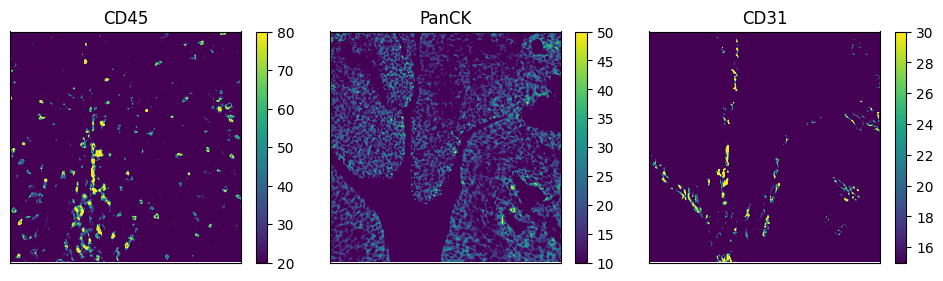

In [64]:
# Plot on original markers. need to adjust treshhold for proper interpretation

markers = {
    'CD45': {'column': 'CD45_Cell_Mean', 'vmin': 20, 'vmax': 80, 'title': 'CD45'},
    'PanCK': {'column': 'PanCK_Cell_Mean', 'vmin': 10, 'vmax': 50, 'title': 'PanCK'},
    'CD31': {'column': 'CD31_Cell_Mean', 'vmin': 15, 'vmax': 30, 'title': 'CD31'}
}

fig, axes = plt.subplots(1, len(markers.keys()), figsize = (12, 3),gridspec_kw = {'wspace': 0.1})

# Plot each marker
for ax, (marker, info) in zip(axes, markers.items()):
    ix = int(np.where(plot_df.columns == info['column'])[0])
    scatter = ax.imshow(image_sset[ix,:,:],
                        vmin = info['vmin'], 
                        vmax = info['vmax'],
                        cmap = 'viridis')
    ax.set_title(info['title'])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(scatter, ax = ax)
plt.show()

In [111]:
plot_df['original_cell'] = [f'cell_{id}' for id in range(0, plot_df.shape[0])]
plot_df['Object.ID'] = [segmentation_utils.generate_key() for id in range(0, plot_df.shape[0])]
plot_df.set_index('Object.ID', inplace = True)

In [118]:
importlib.reload(segmentation_utils)

<module 'segmentation_utils' from '/Users/jabrand2/Desktop/fluoroforest/src/functions/segmentation_utils.py'>

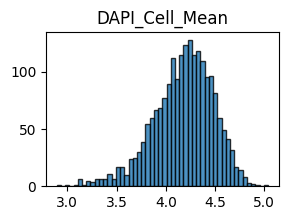

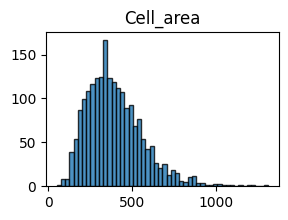

In [65]:
plot_df['Cell_area'] = [segmentation_utils.calc_cell_area(cell) for cell in expanded_outlines]

segmentation_utils.qc_plots(expression_data = plot_df, plot_show = 1)
segmentation_utils.qc_plots(expression_data = plot_df, plot_show = 2)

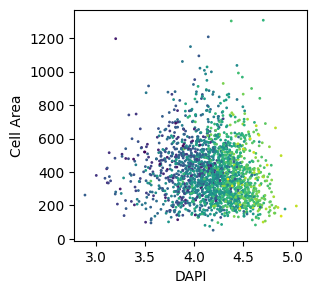

In [69]:
plot_df.loc[:,'mean_rank'] = segmentation_utils.calculate_mean_ranks(plot_df)
plt.figure(figsize = (3,3))
plt.scatter(x = plot_df['DAPI_Cell_Mean'], 
            y = plot_df['Cell_area'], 
            c = plot_df['mean_rank'],
            s = 1)
plt.xlabel('DAPI')
plt.ylabel('Cell Area')
plt.show()

# plot_df.loc[:,'size_qc'] = 'keep'
# plot_df.loc[plot_df['Cell_area'] < 80,'size_qc'] = 'drop'

In [72]:
# save outlines of cell_ids: 
geometry = defaultdict(list)

# to use cells for annotation pipeline (other environment needed)

for i, cell_id in enumerate(plot_df.index.tolist()):
    x = [float(num) for num in expanded_outlines[i][:,0]]
    y = [float(-1*num) for num in expanded_outlines[i][:,1]] # correct orientation in how the image is presented
    geometry[cell_id] = [x,y]

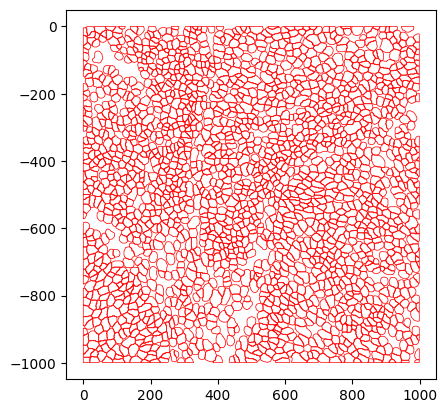

In [73]:
# confirm outlines are as expected
def plot_polygons(polygon_dict):
    fig, ax = plt.subplots()
    
    for name, coords in polygon_dict.items():
        x, y = coords
        polygon = Polygon(np.column_stack([x, y]), fill = None, edgecolor = 'r', linewidth = 0.5)
        ax.add_patch(polygon)
    ax.autoscale()
    ax.set_aspect('equal')
    plt.show()

plot_polygons(geometry)